In [34]:
import numpy as np
import os
import cv2
import glob
import tensorflow as tf
from densenet import densenet_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

tf.test.is_gpu_available()

Memory growth must be set at program startup


True

In [36]:
# hyperparameters
# data
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
horizontal_flip = True
vertical_flip = True
shear_range = 0.2
zoom_range = 0.3
size = (512,512)

# model
growth_rate = 32
nb_layers = [6,12]
reduction = 0.5

# training
lr = 0.003
epochs = 200
max_patience = 50
batch_size = 16

models_directory = 'results/models/'
identifier = '6-12-growth-32-densenet2019_08_26-07:44:06'

In [37]:
origin_dir = '../../data/best-artworks-of-all-time/'
images_dir = origin_dir + 'images/'
x = []
y = []
i = 0
for artist in os.listdir(images_dir):
    for filename in glob.glob(images_dir + artist +'/*.jpg'):
        x.append(filename)
        y.append(i)
    i += 1
n_classes = len(np.unique(y))

In [38]:
classes = np.unique(y)
n_classes = len(classes)
class_weights = compute_class_weight('balanced', 
                                     classes,
                                     y)
y = tf.keras.utils.to_categorical(y)

In [39]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip = vertical_flip,
    shear_range=shear_range,
    zoom_range=zoom_range,
    fill_mode='constant',
    cval=0)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [40]:
img_shape = cv2.resize(cv2.imread(x[0]), size).shape
model = densenet_model(classes=n_classes, shape=img_shape, growth_rate=growth_rate, nb_layers=nb_layers, reduction=reduction)
model.load_weights(models_directory + 'best' + identifier + '.h5')

In [41]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def weightedLoss(originalLossFunc, weightsList):

    @tf.function
    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = tf.argmax(true, axis=axis, output_type=tf.int32) 

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [tf.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [tf.cast(x, tf.float32) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc
loss_object = weightedLoss(loss_object, class_weights)

optimizer = tf.keras.optimizers.Adam()

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [43]:
@tf.function
def test_step(images, labels):
    predictions = model(tf.cast(images, tf.float32), training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    return predictions

In [44]:
train_size = 0
for artist in os.listdir(origin_dir + 'train/'):
    train_size += len(glob.glob(origin_dir + 'train/' + artist +'/*.jpg'))
        
test_size = 0
for artist in os.listdir(origin_dir + 'test/'):
    test_size += len(glob.glob(origin_dir + 'test/' + artist +'/*.jpg'))

In [45]:
# create data generators
test_gen = test_datagen.flow_from_directory(origin_dir + 'test/', target_size=size, batch_size=batch_size, shuffle=False)


Found 1690 images belonging to 50 classes.


In [60]:
all_labels = np.array([]).reshape(0,n_classes)
all_labels.shape

(0, 50)

In [77]:
all_labels = np.array([]).reshape(0,n_classes)
for test_images, test_labels in test_gen:
    print(test_labels.shape)
    all_labels = np.vstack((all_labels, test_labels))
    break
all_labels

(16, 50)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [12]:

batches = 0
all_labels = np.array()
all_predictions = np.array()
for test_images, test_labels in test_gen:
    all_labels.stack(test_labels)
    all_predictions.stack += [test_step(test_images, test_labels)]
    batches += 1
    if batches >= test_size / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
        

Found 1690 images belonging to 50 classes.


In [31]:
test_accuracy.result()

<tf.Tensor: id=8378, shape=(), dtype=float32, numpy=0.03727811>

In [17]:
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

In [30]:
np.unique(np.argmax(all_labels, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 75,  51,  44,  16,  33,  13,  11,  25,  20,  28, 135,  21,   8,
         16,   4,  63,  25,   6,  30,  22,  13,  44,  10,  15,  34,   4,
         13,  16,  24,  34,  45,   8,  29,  93,   7,  59,  30,  27,  67,
         18,  27,  18,  63,  31,  28,  28,  49,  21, 179,  10]))

In [69]:
np.unique(np.argmax(all_labels, axis=1), return_counts=True)

(array([19]), array([16]))

In [65]:
plt.bar(classes,np.argmax(all_labels, axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

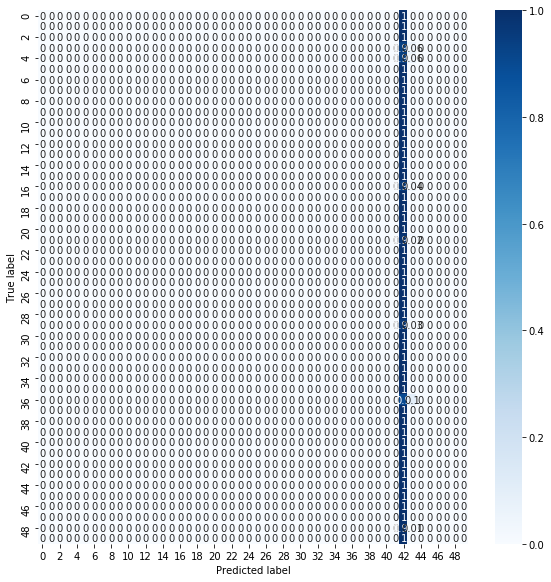

In [32]:
con_mat = tf.math.confusion_matrix(
    labels=np.argmax(all_labels, axis=1), 
    predictions=np.argmax(all_predictions, axis=1),
    num_classes=n_classes).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()